In [1]:
import re
import math
import json
from typing import (
    List,
    Union, 
    Sequence,
    Callable
)

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.core.display import HTML
from IPython.display import display

import spacy
from spacy import displacy
from spacy.tokens import Doc
from spacy.language import Language
from spacy_langdetect import LanguageDetector

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
MODELS = { 
    'EL': spacy.util.get_lang_class('el')(),
    'DE': spacy.util.get_lang_class('de')(),
}

COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'stern_yellow': '#c3c31d',
    'stern_blue': '#0b3f7e',
    'stern_purple': '#7c7cf8',
    'stern_darkbrown': '#370306',
    'darkgreen': '#006400',
    'orange': '#f4a460',
    'green': '#90ee90',
    'blue': '#add8e6',
    'purple': '#800080',
    'err': '#b4b446',
    'Gold': "#FFD700",
    'Light Green': "#90EE90",
    'Light Salmon': "#FFA07A",
    'Pale Turquoise': "#AFEEEE",
    'Light Coral': "#F08080",
    'Light Blue': "#ADD8E6",
    'Light Pink': "#FFB6C1",
    'Moccasin': "#FFE4B5",
    'Powder Blue': "#B0E0E6",
    'Light Grey': "#D3D3D3",
    'Lavender': "#E6E6FA",
    'Navajo White': "#FFDEAD",
    'Wheat': "#F5DEB3",
    'Lemon Chiffon': "#FFFACD",
    'Dark Khaki': "#BDB76B",
    'Light Slate Blue': "#8787df",
    'Light Cyan': "#E0FFFF",
}

MORPH_LOC = {
    "Case"       : "Πτώσεις",
    "Gender"     : "Γένος",
    "Number"     : "Αριθμός",
    "Person"     : "Πρόσωπο",
    "Tense"      : "Χρόνος",
    "VerbForm"   : "Μορφή ρήματος",
    "Mood"       : "Ρήμα",
    "Voice"      : "Φωνή",
    "Definite"   : "Οριστικότητα",
    "Degree"     : "Βαθμίδα",
    "Poss"       : "Κτητικότητα",
    "NumType"    : "Τύπος αριθμού",
    "PronType"   : "Τύπος αντωνυμίας",
    "AdpType"    : "Τύπος προθέσης",
    "AdvType"    : "Τύπος επιρρήματος",
    "VerbType"   : "Τύπος ρήματος",
    "Aspect"     : "Απόψη",
    "Subcat"     : "Υποκατηγορία",
    "Foreign"    : "Ξενική λέξη",
    "Typo"       : "Ορθογραφικό λάθος",
    "SpaceAfter" : "Κενό μετά",
    "PunctType"  : "Τύπος στίξης",
    "PunctSide"  : "Πλευρά στίξης",
    "Hyph"       : "Παύλα",
    "NumForm"    : "Μορφή αριθμού",
}

# http://universaldependencies.org/u/pos/
# extracted from https://github.com/explosion/spaCy/blob/57a230c6e4844d368d4d12b09993877fc9e50946/spacy/glossary.py#L23
UPOS_TAGS = {
    "ADJ": "adjective",
    "ADP": "adposition",
    "ADV": "adverb",
    "AUX": "auxiliary",
    "CONJ": "conjunction",
    "CCONJ": "coordinating conjunction",
    "DET": "determiner",
    "INTJ": "interjection",
    "NOUN": "noun",
    "NUM": "numeral",
    "PART": "particle",
    "PRON": "pronoun",
    "PROPN": "proper noun",
    "PUNCT": "punctuation",
    "SCONJ": "subordinating conjunction",
    "SYM": "symbol",
    "VERB": "verb",
    "X": "other",
    "EOL": "end of line",
    "SPACE": "space",
}

UPOS_COLORS = dict(zip(UPOS_TAGS.keys(), COLORS.values()))

TAG_ENT_TEMPLATE = """
<mark style="color: #fff; background: {bg}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    {text}
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 1ch">{label}{kb_link}</span>
</mark>
"""

def get_lang_detector(nlp, name):
    return LanguageDetector()

def vcu(df_grouped, col, *args):
    """Returns the value counts unstacked of a column of a grouped DataFrame."""
    return df_grouped[col].value_counts().unstack()

def meets_plot_criteria(
    df: pd.DataFrame,
    col: str,
    *,
    grouped: pd.DataFrame, 
    func: Callable,
    func_args: Sequence = None,
) -> bool:
    return  (col[0].isupper()
             # do not plot columns with only one value
             and len(df[col].value_counts()) > 1
             # do not plot columns with only one language 
             and len(grouped[col].value_counts()) > 1
             # do not plot columns with values only in one language
             and len(func(grouped, col, func_args)) > 1)

def convert_to_lang_tick(lang: str, level: int = 1) -> str:
    """Returns the language ticks for the plots."""
    level = level - 1
    lang = lang.removeprefix('(').removesuffix(')').replace("'", '')
    lang = lang.upper()
    return lang.split(',')[level].strip()

In [3]:
UPOS_COLORS

{'ADJ': '#a52040',
 'ADP': '#404080',
 'ADV': '#c3c31d',
 'AUX': '#0b3f7e',
 'CONJ': '#7c7cf8',
 'CCONJ': '#370306',
 'DET': '#006400',
 'INTJ': '#f4a460',
 'NOUN': '#90ee90',
 'NUM': '#add8e6',
 'PART': '#800080',
 'PRON': '#b4b446',
 'PROPN': '#FFD700',
 'PUNCT': '#90EE90',
 'SCONJ': '#FFA07A',
 'SYM': '#AFEEEE',
 'VERB': '#F08080',
 'X': '#ADD8E6',
 'EOL': '#FFB6C1',
 'SPACE': '#FFE4B5'}

In [4]:
class TextAnalyzer:
    """A class to analyse a text and return a quantitative analysis of the:
    - number of words/tokens
    - POS tags
    - morphological features
    - syntactic dependencies
    - named entities
    - lemmas
    - word vectors
    - similarity between words
    - similarity between sentences"""

    def __init__(self) -> None:
        self.nlp_models = {}
        self.nlp_el = spacy.load('el_core_news_lg')
        Language.factory('language_detector', func=get_lang_detector)
        self.nlp_el.add_pipe('language_detector', last=True)
        self.remove_crossrefs = True
        self.digits_to_zeros = True
        self.remove_punct = True

    def detect_language(self, text: str) -> str:
        doc = self.nlp_el(text)
        return doc._.language['language']

    def load_model(self, lang: str) -> None:
        spacy_models = {
            'el': 'el_core_news_lg',
            'de': 'de_core_news_lg',
        }
        lang = lang.lower()
        if lang in spacy_models:
            if lang not in self.nlp_models:
                self.nlp_models[lang] = spacy.load(spacy_models[lang])
            return self.nlp_models[lang]
        else:
            raise ValueError(f"No available model for language: {lang}")

    @staticmethod
    def get_lang_model(lang: str) -> Language:
        return MODELS[lang]

    def _remove_crossrefs(self, text: str) -> str:
        """Remove cross references from text.
        A cross reference is a string of the form (ΑΚ 123) or (BGB § 123)."""
        pattern = r'\((ΑΚ|AK|BGB)[\s§]*\d+\)'
        return re.sub(pattern, '', text)

    def _digits_to_zeros(self, text: str) -> str:
        """Replace all numbers with zeros (including article numbers),
        maintaining the same length of the string."""
        return re.sub(r'\d', '0', text)

    def _remove_punctuation(self, text: str) -> str:
        """Remove punctuation from text."""
        return re.sub(r'[^\w\s]', '', text)

    def preprocess(
            self, 
            text: str,
            *,
            remove_crossrefs: bool = False,
            digits_to_zeros: bool = True,
            remove_punctuation: bool = True,
    ) -> str:
        """Preprocess text by removing cross references and punctuation,
        and replacing numbers with zeros."""
        if remove_crossrefs:
            text = self._remove_crossrefs(text)
        if digits_to_zeros:
            text = self._digits_to_zeros(text)
        if remove_punctuation:
            text = self._remove_punctuation(text)
        return text


    def word_freqs(
            self,
            text: str,
            *, 
            preprocess: bool = True,
            exclude_stopwords: bool = False, 
            lemmas: bool = False
    ) -> dict:
        """Count a dict with the number of words in a text.
        If `lemmas` is False, the number of tokens is returned, otherwise the 
        number of lemmas."""
        text = text.lower()
        if preprocess:
            text = self.preprocess(text, 
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        if lemmas:
            words = [token.lemma_ for token in doc]
        else:
            words = [token.text for token in doc]
        if exclude_stopwords:
            words = [word for word in words 
                     if not word in self.nlp.Defaults.stop_words]
        return pd.Series(words).value_counts().to_dict()

    def analyze(
            self, 
            text: str, 
            *, 
            preprocess: bool = True,
            as_dataframe: bool = False
    ) -> Union[dict, pd.DataFrame]:
        if preprocess:
            text = self.preprocess(text, 
                                   remove_crossrefs=self.remove_crossrefs,
                                   digits_to_zeros=self.digits_to_zeros,
                                   remove_punctuation=self.remove_punct)
        lang = self.detect_language(text)
        nlp = self.load_model(lang)
        doc = nlp(text)
        analysis = {
            'preprocessed_text': text,
            'detected_lang': doc._.language['language'].upper(),
            'num_tokens': len(doc),
            'token_freqs': self.word_freqs(text),
            'lemma_freqs': self.word_freqs(text, lemmas=True),
            'pos_tags': [tkn.pos_ for tkn in doc],
            'pos_freqs': {pos: len([tkn for tkn in doc if tkn.pos_ == pos]) 
                          for pos in set([tkn.pos_ for tkn in doc])},
            'morph_features': json.dumps(
                [{tkn.text: {'POS': tkn.pos_, **tkn.morph.to_dict()} 
                  for tkn in doc if len(tkn.morph.to_dict()) > 0}], 
                ensure_ascii=False
            ),
            'syntax_deps': [tkn.dep_ for tkn in doc],
            'named_entities': [(ent.text, ent.label_) for ent in doc.ents],
            'lemmas': [tkn.lemma_ for tkn in doc],
            'word_vectors': [tkn.vector for tkn in doc],
            'avg_vector': np.mean([tkn.vector for tkn in doc], axis=0)
        }
        if as_dataframe:
            return pd.DataFrame(analysis, encoding='utf-8')
        return analysis

    class CustomTagger:
        def __init__(self, nlp):
            self.nlp = nlp

        def __call__(self, doc: Doc) -> Doc:
            for token in doc:
                token.tag_ = token.pos_
            return doc

    if not Language.has_factory("custom_tagger"):
        @Language.factory("custom_tagger")
        def create_custom_tagger(nlp, name):
            return TextAnalyzer.CustomTagger(nlp)

    def get_pos_tags(self, text: str, model: str) -> list:
        nlp = self.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        # get the POS tags directly from the Doc object
        pos_tags = [token.pos_ for token in doc]
        pos_tags = sorted(list(set(pos_tags)))

        return pos_tags

class ComparisonVisualizer:
    def __init__(self, dataframe: pd.DataFrame, analyzer: TextAnalyzer) -> None:
        self.dataframe = dataframe
        self.analyzer = analyzer

    def compare_texts(
            self, 
            *, 
            group_by: str = None
    ) -> None:
        grouped_df = self.dataframe.groupby(group_by)

        for _, group in grouped_df:
            data = []
            for _, row in group.iterrows():
                text = row['sentence']
                analysis = self.analyzer.analyze(text, preprocess=True)
                data.append(analysis)

            df_analysis = pd.DataFrame(data)
            self.visualize_analysis(df_analysis)

    def visualize_analysis(self, df_analysis: pd.DataFrame) -> None:
        cols_with_numeric_values = df_analysis.select_dtypes(np.number).columns
        print(cols_with_numeric_values)
        df_analysis[cols_with_numeric_values].plot.bar(rot=0)
        plt.show()

    def compare_sentence_similarity(self, df_analysis):
        sentence_vectors = np.stack(df_analysis['avg_vector'].values)
        similarities = cosine_similarity(sentence_vectors)
        return similarities

    def sentence_similarity_heatmap(
            self, 
            df_analysis, 
            *, 
            group_by: Union[str, list] = None
    ) -> None:
        """Plot a heatmap of sentence similarities, grouped by language 
        along with the sentences."""
        similarities = self.compare_sentence_similarity(df_analysis)
        if group_by is None:
            example_id = df_analysis['id'].iloc[0]
            fig, ax = plt.subplots()
            ax.set_title('Ομοιότητα προτάσεων')
            ax.set_xticks(np.arange(len(df_analysis)))
            ax.set_yticks(np.arange(len(df_analysis)))
        else:
            grouped_df = df_analysis.groupby(group_by)
            for _, group in grouped_df:
                lang = group['lang'].iloc[0]
                example_id = group['id'].iloc[0]
                sentences = group['sentence'].values
                print(len(sentences))
                fig, ax = plt.subplots()
                ax.set_xticks(np.arange(len(sentences)))
                ax.set_yticks(np.arange(len(sentences)))
                ax.set_title(f'Ομοιότητα προτάσεων ({lang})')
        fig.suptitle(f'Παράδειγμα {example_id}')
        im = ax.imshow(similarities, cmap='hot', interpolation='nearest')
        ax.set_xticklabels(df_analysis['version'], rotation=45, ha="right")
        ax.set_yticklabels(df_analysis['version'])
        # display the values over 0.5 inside the heatmap
        for i, _ in enumerate(similarities):
            for j, _ in enumerate(similarities):
                if similarities[i, j] >= 0.4:
                    text = ax.text(j, i, round(similarities[i, j], 2),
                                   ha='center', va='center')
        plt.colorbar(im)
        plt.show()

    def _prepare_morphology_data(
            self, 
            df_analysis: pd.DataFrame,
            *,
            meta_columns: list = ['id', 'lang', 'version'],
            morph_column: str = 'morph_features'
    ) -> pd.DataFrame:
        df = df_analysis[meta_columns + [morph_column]].copy()
        df['morph_features'] = df['morph_features'].apply(json.loads)
        df = df.explode('morph_features')
        df = pd.concat([df.drop(['morph_features'], axis=1), 
                        df['morph_features'].apply(pd.Series, dtype='object')
                        .stack().reset_index(level=1, name='morphology')],
                       axis=1)
        df = pd.concat([df.drop(['morphology'], axis=1), 
                        df['morphology'].apply(pd.Series, dtype='object')], 
                       axis=1)
        # df = df.rename(columns={'POS': 'pos'})
        return df


    def visualize_morphology(
            self, 
            df_analysis: pd.DataFrame,
            *, 
            colors: Sequence = None, 
            group_by: Union[str, list] = None,
    ) -> None:
        if colors is None:
            colors = mpl.colormaps['tab20'] # old version: plt.cm.tab20

        df = self._prepare_morphology_data(df_analysis)

        df_grouped = df.groupby(group_by)
        cols = [col for col in df.columns 
                if meets_plot_criteria(df, col, grouped=df_grouped, func=vcu)]

        num_plots = len(cols)
        n_rows = math.ceil(num_plots / 2)
        n_cols = 2 if num_plots > 1 else 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        fig.suptitle(f"Παράδειγμα {df['id'].iloc[0]}")

        for i, col in enumerate(cols):
            ax = axes[i // n_cols, i % n_cols]
            ax.set_title(MORPH_LOC.get(col, col))
            (df_grouped[col]
                .value_counts()
                .unstack()
                .plot(
                    kind='bar', 
                    ax=ax, 
                    color=[list(COLORS.values())[i] 
                           for i, _ in enumerate(vcu(df_grouped, col).columns)],
                    stacked=True, 
                    sharey=True, 
                    rot=0, 
                    zorder=3
                )
            )
            langs = [convert_to_lang_tick(str(idx))
                     for idx in vcu(df_grouped, col).index]
            ax.set_xticklabels(langs)
            # make sure y ticks are rounded to the nearest integer,
            # without showing zero
            ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_xlabel(None)
            ax.set_ylabel('Απόλυτη συχνότητα')
            ax.legend().set_title(None)
            ax.legend(loc='lower center')
            ax.grid(axis='both', color='lightgray', zorder=0)

        # check if the number of plots is odd and remove the last subplot
        if num_plots % 2 != 0:
            fig.delaxes(axes[-1, -1])

        plt.show()

    def visualize_pos(self, text: str, model: str, *, colors: dict) -> None:
        nlp = self.analyzer.load_model(model)

        if 'custom_tagger' not in nlp.pipe_names:
            nlp.add_pipe('custom_tagger', before='morphologizer')

        doc = nlp(text)

        pos_tags = self.analyzer.get_pos_tags(text, model)

        ents = []
        for token in doc:
            if token.pos_ in pos_tags:
                ents.append({'start': token.idx,
                             'end': token.idx + len(token),
                             'label': token.pos_})

        doc = {'text': text, 'ents': ents}

        options = {'ents': pos_tags, 'colors': colors,
                   'template': TAG_ENT_TEMPLATE}

        html = displacy.render(doc,
                               style='ent',
                               options=options,
                               manual=True,
                               jupyter=True,
                               )
        display(HTML(html))

In [5]:
df = pd.read_csv('examples.csv', encoding='utf-8')

with pd.option_context('display.max_colwidth', None):
    display(df)

,id,lang,version,sentence
0,1,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)
1,1,EL,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173)
2,1,DE,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133)
3,1,DE,ελλΑΚ-1951,"Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften."
4,2,EL,ελλΑΚ-1940,"Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)"
5,2,EL,ελλΑΚ-2023,"Στις προθεσμίες που καθορίζονται με νόμο, δικαστική απόφαση ή δικαιοπραξία ισχύουν οι ερμηνευτικές διατάξεις των άρθρων 241 έως 246. (AK 240)"
6,2,DE,γερΑΚ-2023,"Für die in Gesetzen, gerichtlichen Verfügungen und Rechtsgeschäften enthaltenen Frist- und Terminsbestimmungen gelten die Auslegungsvorschriften der §§ 187 bis 193. (BGB § 186)"
7,2,DE,ελλΑΚ-1951,"Für die Fristen, welche durch Gesetz, gerichtliche Entscheidung oder Rechtsgeschäft bestimmt werden, gelten die Auslegungsvorschriften der Art. 241 bis 246."
8,3,EL,ελλΑΚ-1940,"Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)"
9,3,EL,ελλΑΚ-2023,"Η συγκατάθεση που παρέχεται μετά την επιχείρηση της δικαιοπραξίας (έγκριση), εφόσον δεν ορίζεται το αντίθετο, ανατρέχει στο χρόνο της δικαιοπραξίας. (AK 238)"


Index(['num_tokens'], dtype='object')


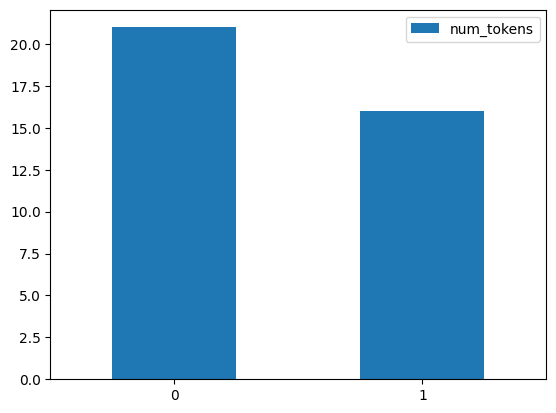

Index(['num_tokens'], dtype='object')


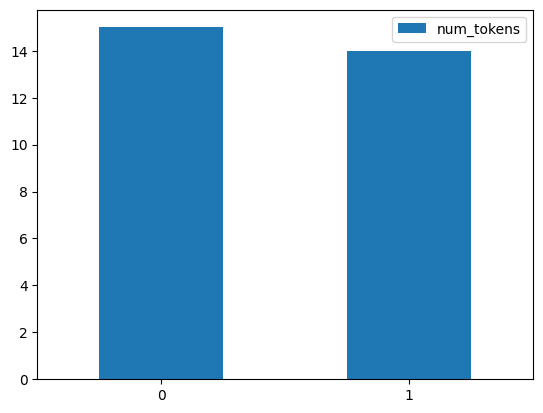

Index(['num_tokens'], dtype='object')


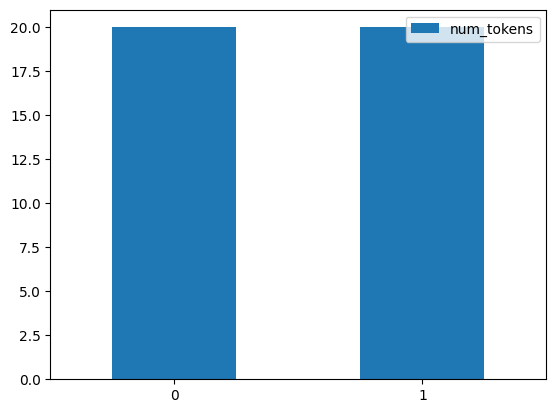

Index(['num_tokens'], dtype='object')


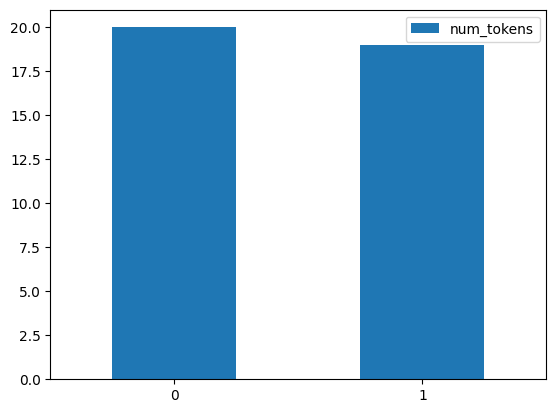

Index(['num_tokens'], dtype='object')


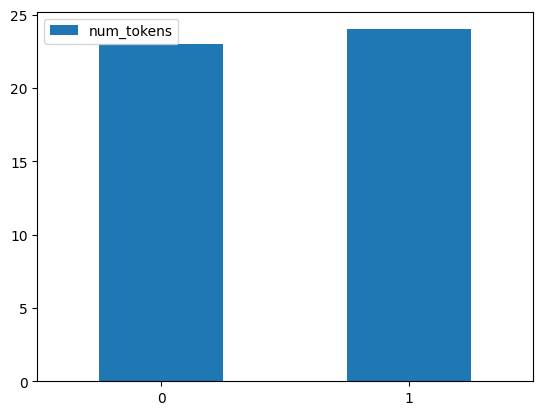

Index(['num_tokens'], dtype='object')


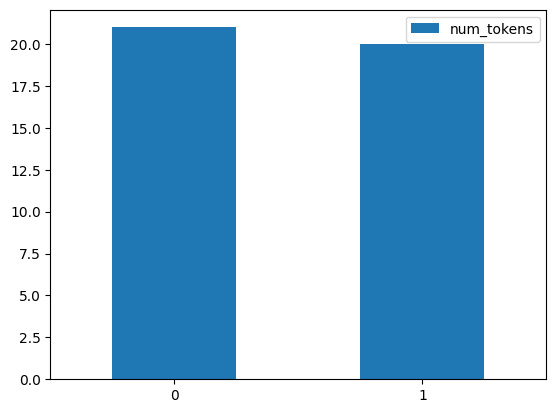

Index(['num_tokens'], dtype='object')


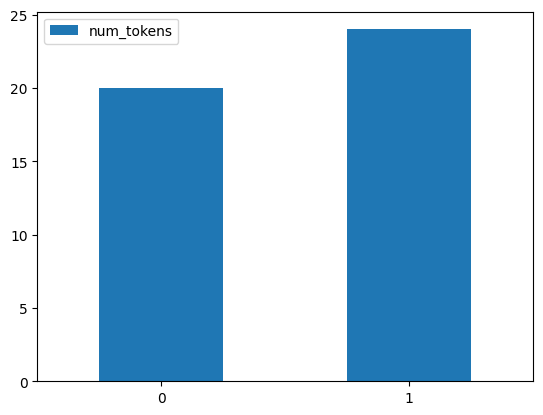

Index(['num_tokens'], dtype='object')


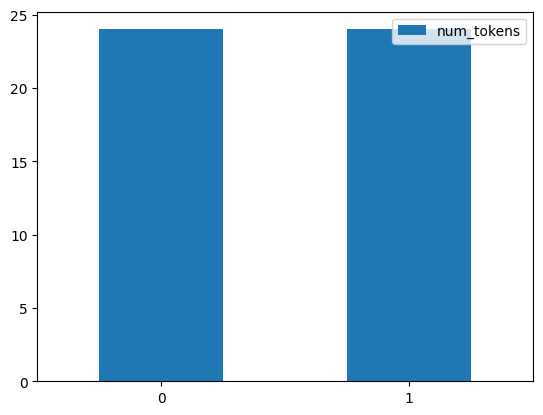

Index(['num_tokens'], dtype='object')


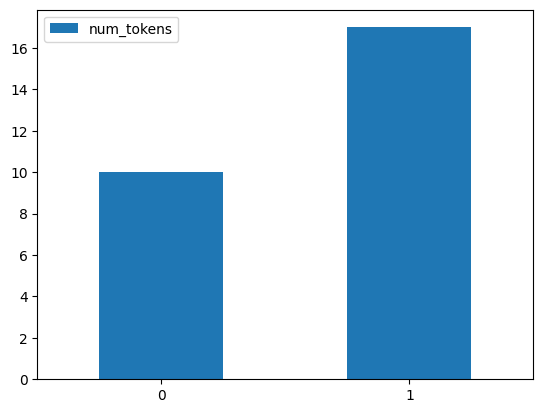

Index(['num_tokens'], dtype='object')


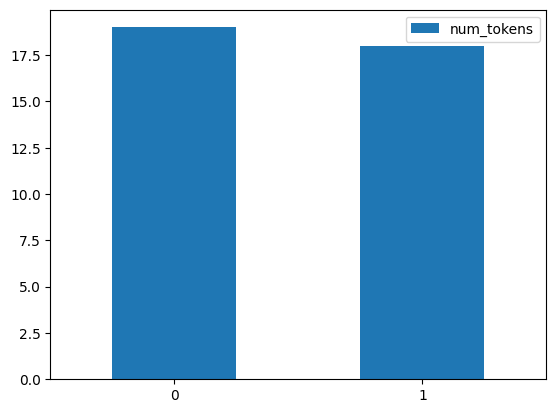

In [6]:
analyzer = TextAnalyzer()
visualizer = ComparisonVisualizer(df, analyzer)
visualizer.compare_texts(group_by=['id', 'lang'])

In [7]:
# Perform analysis and store the results in a DataFrame
data = []
for _, row in df.iterrows():
    analysis = analyzer.analyze(row['sentence'])
    data.append(analysis)

df_analysis = pd.DataFrame(data)
analysis_df = pd.concat([df, df_analysis], axis=1)
analysis_df.to_csv('analysis.csv', encoding='utf-8', index=False)
analysis_df

,id,lang,version,sentence,preprocessed_text,detected_lang,num_tokens,token_freqs,lemma_freqs,pos_tags,pos_freqs,morph_features,syntax_deps,named_entities,lemmas,word_vectors,avg_vector
0,1,EL,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζ...,EL,15,"{'κατὰ': 1, 'τὴν': 1, 'ἑρμηνείαν': 1, 'τῆς': 1...","{'κατὰ': 1, 'τὴν': 1, 'ἑρμηνείαν': 1, 'τῆς': 1...","[ADP, DET, NOUN, DET, NOUN, NOUN, VERB, PROPN,...","{'ADV': 1, 'ADJ': 2, 'NOUN': 5, 'PROPN': 1, 'V...","[{""τὴν"": {""POS"": ""DET"", ""Case"": ""Acc"", ""Defini...","[ROOT, det, obj, det, nsubj:pass, nmod, acl:re...","[(προσηλώσεως εἱς, PERSON)]","[κατὰ, τὴν, ἑρμηνείαν, τῆς, δηλώση, βουλήσεω, ...","[[-0.46623, -0.21746, 1.6179, -0.53593, 1.1153...","[-0.23394278, -1.2499799, 0.6196643, 1.0968503..."
1,1,EL,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητ...,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητ...,EL,14,"{'κατά': 1, 'την': 1, 'ερμηνεία': 1, 'της': 1,...","{'ο': 3, 'κατά': 1, 'ερμηνεία': 1, 'δήλωση': 1...","[ADP, DET, NOUN, DET, NOUN, NOUN, VERB, DET, A...","{'ADJ': 1, 'NOUN': 6, 'VERB': 1, 'DET': 3, 'AD...","[{""την"": {""POS"": ""DET"", ""Case"": ""Acc"", ""Defini...","[case, det, obl, det, nmod, nmod, ROOT, det, a...",[],"[κατά, ο, ερμηνεία, ο, δήλωση, βουλήσεω, αναζη...","[[-0.38512, 1.8681, -1.8542, -1.4578, 1.9544, ...","[-1.3567731, 0.7651764, 0.5505403, 1.2239096, ..."
2,1,DE,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist d...,Bei der Auslegung einer Willenserklärung ist d...,DE,21,"{'zu': 2, 'der': 2, 'bei': 1, 'nicht': 1, 'aus...","{'der': 4, 'zu': 2, 'erforschen': 1, 'Ausdruck...","[ADP, DET, NOUN, DET, NOUN, AUX, DET, ADJ, NOU...","{'AUX': 1, 'PART': 3, 'CCONJ': 1, 'ADJ': 2, 'N...","[{""der"": {""POS"": ""DET"", ""Case"": ""Nom"", ""Defini...","[mo, nk, nk, nk, ag, ROOT, nk, nk, sb, pm, oc,...",[],"[bei, der, Auslegung, ein, Willenserklärung, s...","[[-5.3947, -2.2958, 1.3939, -1.6711, 1.8072, -...","[0.9223884, 0.4562371, -1.1321509, -0.07564432..."
3,1,DE,ελλΑΚ-1951,Bei der Auslegung einer Willenserklärung wird ...,Bei der Auslegung einer Willenserklärung wird ...,DE,16,"{'der': 2, 'bei': 1, 'auslegung': 1, 'einer': ...","{'der': 3, 'bei': 1, 'Auslegung': 1, 'ein': 1,...","[ADP, DET, NOUN, DET, NOUN, AUX, DET, ADJ, NOU...","{'AUX': 1, 'PART': 1, 'ADJ': 1, 'NOUN': 4, 'VE...","[{""der"": {""POS"": ""DET"", ""Case"": ""Nom"", ""Defini...","[mo, nk, nk, nk, ag, ROOT, nk, nk, sb, oc, mo,...",[],"[bei, der, Auslegung, ein, Willenserklärung, w...","[[-5.3947, -2.2958, 1.3939, -1.6711, 1.8072, -...","[1.1191075, 0.83995694, -0.73105085, -0.479010..."
4,2,EL,ελλΑΚ-1940,Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου...,Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου...,EL,20,"{'διὰ': 2, '000': 2, 'τὰς': 2, 'ἰσχύουσιν': 1,...","{'διὰ': 2, '000': 2, 'τὰς': 2, 'ἰσχύουσιν': 1,...","[PROPN, DET, NOUN, DET, VERB, ADP, NOUN, ADJ, ...","{'ADJ': 1, 'X': 1, 'NOUN': 9, 'NUM': 2, 'PROPN...","[{""Διὰ"": {""POS"": ""PROPN"", ""Case"": ""Nom"", ""Gend...","[dep, det, ROOT, det, nmod, case, nmod, amod, ...","[(τὰς καθοριζομένας διὰ, GPE)]","[Διὰ, τὰς, προθεσμία, τὰς, καθοριζομένας, διὰ,...","[[1.168, -0.71587, 1.483, 1.1931, -1.4594, 0.6...","[0.5421609, -1.224602, 0.8088211, 1.332979, 0...."
5,2,EL,ελλΑΚ-2023,"Στις προθεσμίες που καθορίζονται με νόμο, δικα...",Στις προθεσμίες που καθορίζονται με νόμο δικασ...,EL,19,"{'000': 2, 'στις': 1, 'προθεσμίες': 1, 'άρθρων...","{'000': 2, 'ο': 2, 'σε ο': 1, 'δικαιοπραξία': ...","[ADP, NOUN, PRON, VERB, ADP, NOUN, ADJ, NOUN, ...","{'CCONJ': 1, 'ADJ': 2, 'PRON': 1, 'NOUN': 6, '...","[{""Στις"": {""POS"": ""ADP"", ""Case"": ""Acc"", ""Gende...","[case, obl, nsubj:pass, acl:relcl, case, obl, ...",[],"[σε ο, προθεσμία, που, καθορίζω, με, νόμος, δι...","[[6.5925, -0.69682, -0.93984, -3.5732, -1.5975...","[-0.15453579, 0.38241363, 0.12903214, 0.588664..."
6,2,DE,γερΑΚ-2023,"Für die in Gesetzen, gerichtlichen Verfügungen...",Für die in Gesetzen gerichtlichen Verfügungen ...,

In [8]:
json.loads(df_analysis['morph_features'][0])

[{'τὴν': {'POS': 'DET',
   'Case': 'Acc',
   'Definite': 'Def',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'ἑρμηνείαν': {'POS': 'NOUN',
   'Case': 'Acc',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'τῆς': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Def',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'δηλώσεως': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'βουλήσεως': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ἀναζητεῖται': {'POS': 'VERB',
   'Aspect': 'Imp',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin',
   'Voice': 'Pass'},
  'ἤ': {'POS': 'PROPN', 'Case': 'Gen', 'Gender': 'Fem', 'Number': 'Plur'},
  'βούλησις': {'POS': 'NOUN',
   'Case': 'Acc',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ἄνευ': {'POS': 'ADJ', 'Case': 'Acc', 'Gender': 'Fem', 'Number': 'Plur'},
  'προσηλώσεως': {'POS': 'ADJ',
   'Case': 'Acc',
   'Gend

In [9]:
json.loads(df_analysis['morph_features'][2])

[{'der': {'POS': 'DET',
   'Case': 'Nom',
   'Definite': 'Def',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Auslegung': {'POS': 'NOUN',
   'Case': 'Dat',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'einer': {'POS': 'DET',
   'Case': 'Gen',
   'Definite': 'Ind',
   'Gender': 'Fem',
   'Number': 'Sing',
   'PronType': 'Art'},
  'Willenserklärung': {'POS': 'NOUN',
   'Case': 'Gen',
   'Gender': 'Fem',
   'Number': 'Sing'},
  'ist': {'POS': 'AUX',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Person': '3',
   'Tense': 'Pres',
   'VerbForm': 'Fin'},
  'wirkliche': {'POS': 'ADJ',
   'Case': 'Nom',
   'Degree': 'Pos',
   'Gender': 'Masc',
   'Number': 'Sing'},
  'Wille': {'POS': 'NOUN', 'Case': 'Nom', 'Gender': 'Masc', 'Number': 'Sing'},
  'erforschen': {'POS': 'VERB', 'VerbForm': 'Inf'},
  'dem': {'POS': 'DET',
   'Case': 'Dat',
   'Definite': 'Def',
   'Gender': 'Masc',
   'Number': 'Sing',
   'PronType': 'Art'},
  'buchstäblichen': {'POS': 'ADJ',
   'Case': 'Dat',
   '

In [10]:
for i, text in enumerate(analysis_df['preprocessed_text'].to_list()):
    html_output = visualizer.visualize_pos(text, 
                                           analysis_df['lang'][i], 
                                           colors=UPOS_COLORS)
    # do not display `<IPython.core.display.HTML object>` in the notebook
    display(html_output, display_id=f'pos_display_{i}') if html_output else None

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

Παράδειγμα 1: Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)


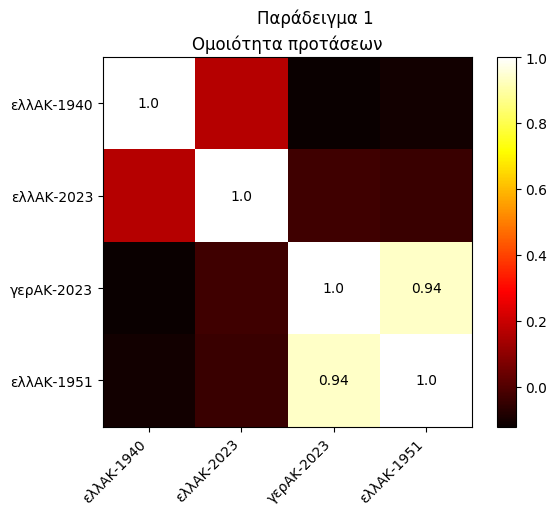

Παράδειγμα 2: Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)


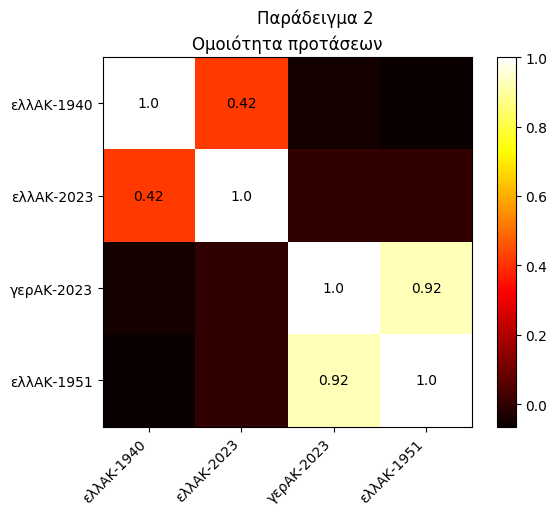

Παράδειγμα 3: Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)


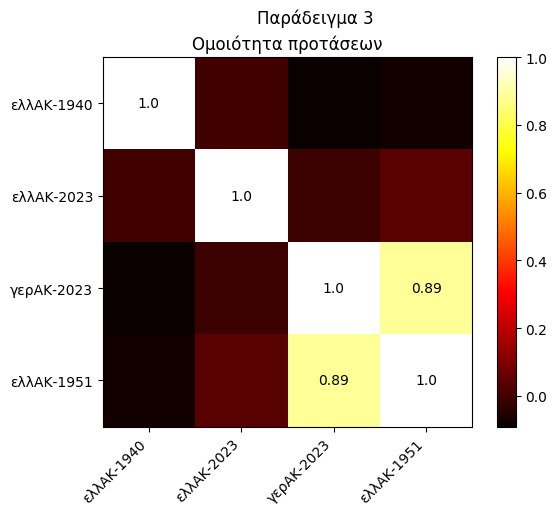

Παράδειγμα 4: Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς σύνολον (κληρονομία) μεταβαίνει ἐκ τοῦ νόμου ἤ ἐκ διαθήκης εἰς ἕν ἤ πλείονα πρόσωπα (κληρονόμοι). (ΑΚ 1710)


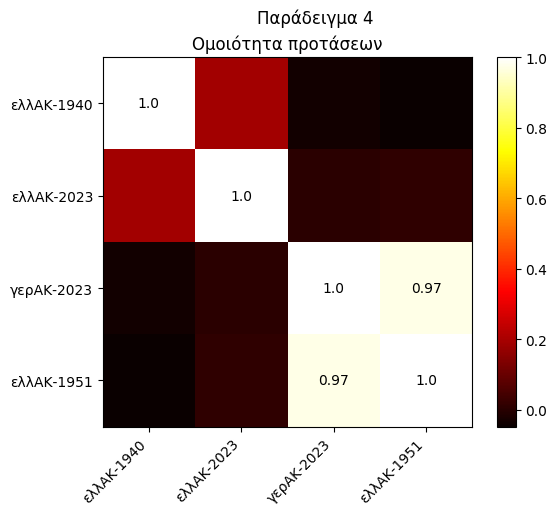

Παράδειγμα 5: Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρόνον τῆς ἐπαγωγῆς τῆς κληρονομίας ἐν ζωῇ εὑρισκόμενος ἤ τουλάχιστον συνειλημμένος. (ΑΚ 1711)


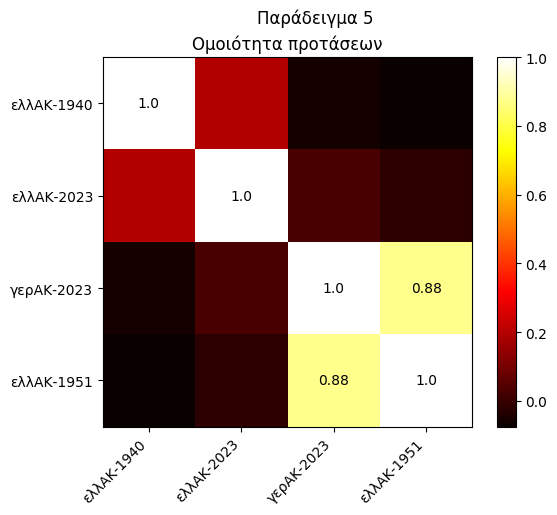

In [11]:
sent_similarities = visualizer.compare_sentence_similarity(analysis_df)

for i, row in analysis_df.groupby('id'):
    print(f'Παράδειγμα {i}:', row['sentence'].iloc[0])
    visualizer.sentence_similarity_heatmap(row)

Παράδειγμα 1: Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)


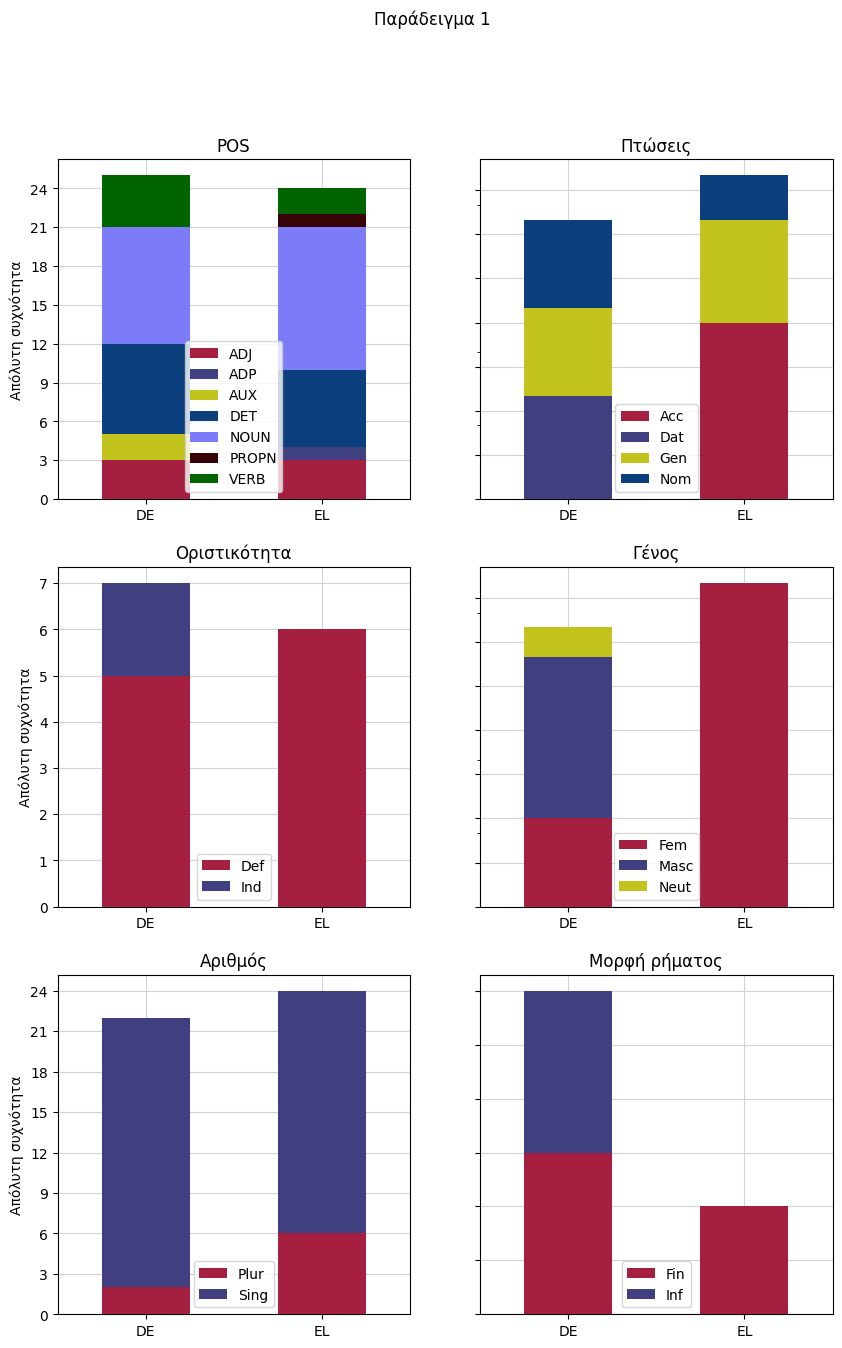

Παράδειγμα 2: Διὰ τὰς προθεσμίας τὰς καθοριζομένας διὰ νόμου, δικαστικῆς αποφάσεως ἤ δικαιοπραξίας ἰσχύουσιν αἱ ἑρμηνευτικαὶ διατάξεις τῶν ἄρθρων 241 ἔως 246. (ΑΚ 240)


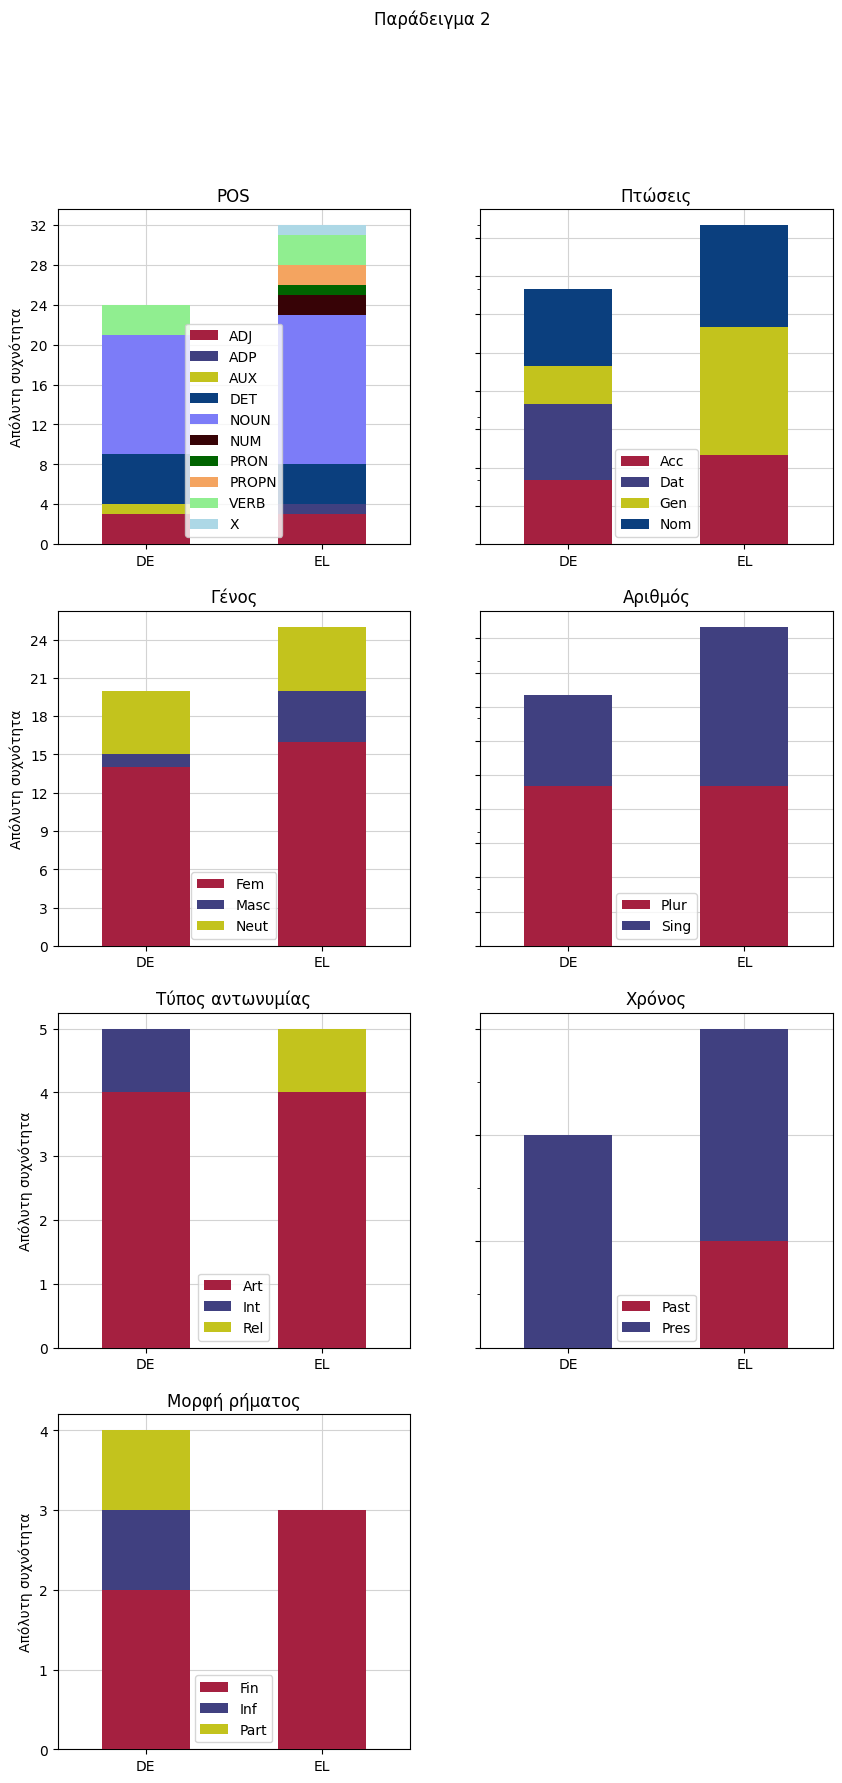

Παράδειγμα 3: Ἡ μετὰ τὴν ἐπιχείρησιν τῆς δικαιπραξὶας παρεχομένη συγκατάθεσις (ἔγκρισις), ἐφ’ ὄσον δὲν ὁρίζεται τὸ ἐναντὶον, ἀνατρέχει εἰς τον χρόνον τῆς δικαιοπραξίας. (ΑΚ 238)


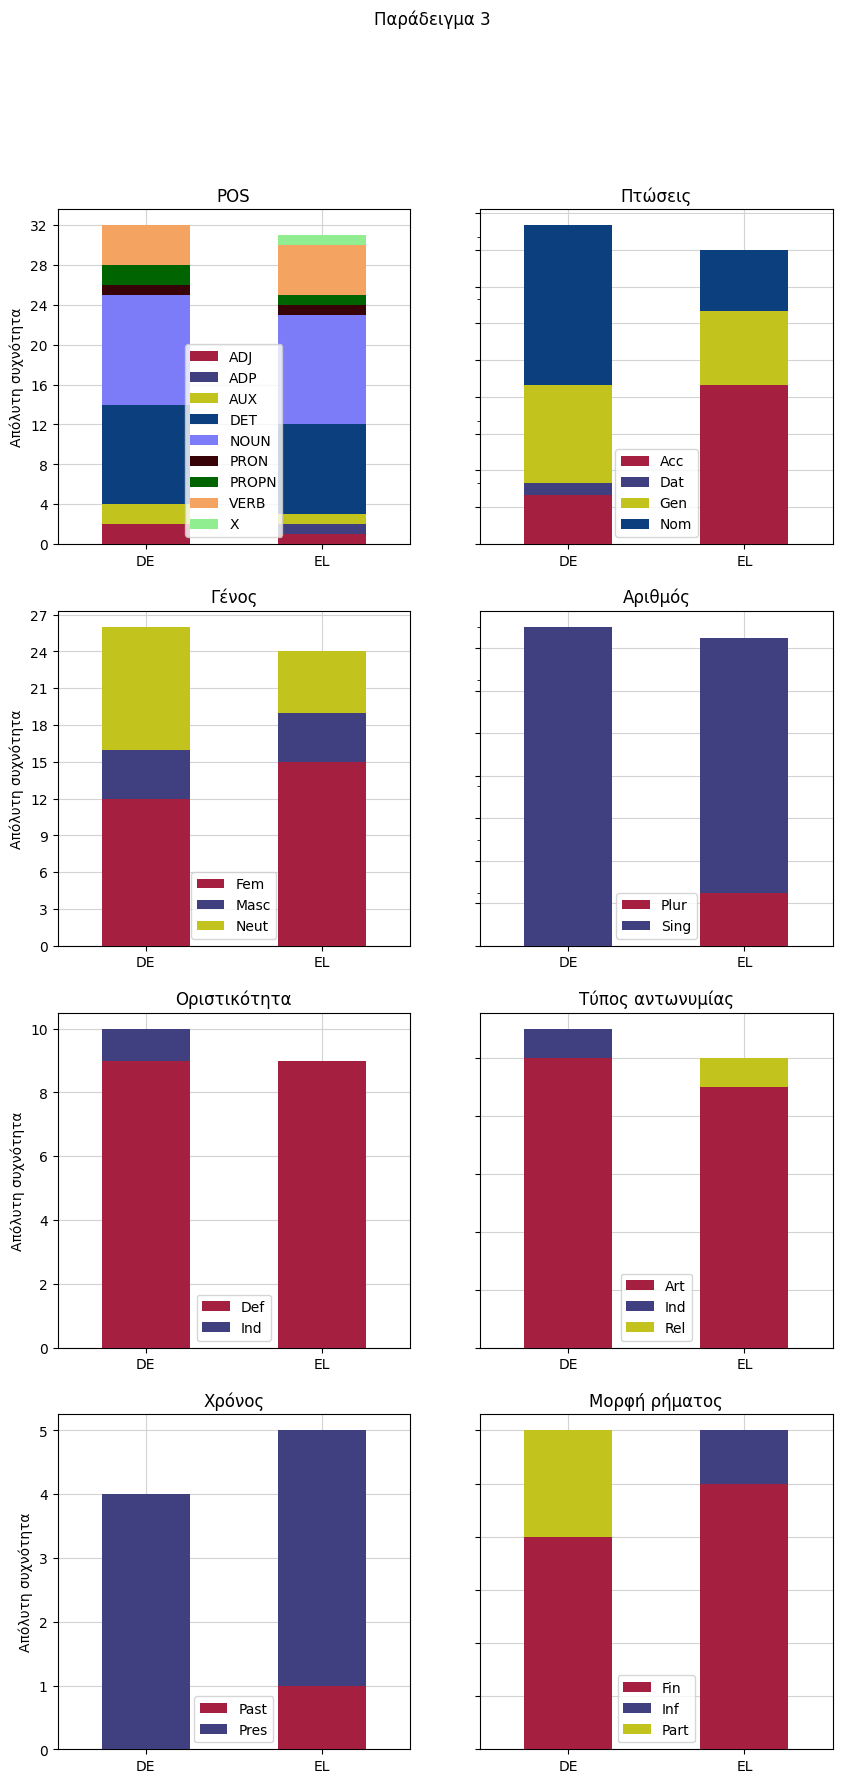

Παράδειγμα 4: Ἅμα τῷ θανάτῳ τοῦ προσώπου ἡ περιουσία αὐτοῦ ὡς σύνολον (κληρονομία) μεταβαίνει ἐκ τοῦ νόμου ἤ ἐκ διαθήκης εἰς ἕν ἤ πλείονα πρόσωπα (κληρονόμοι). (ΑΚ 1710)


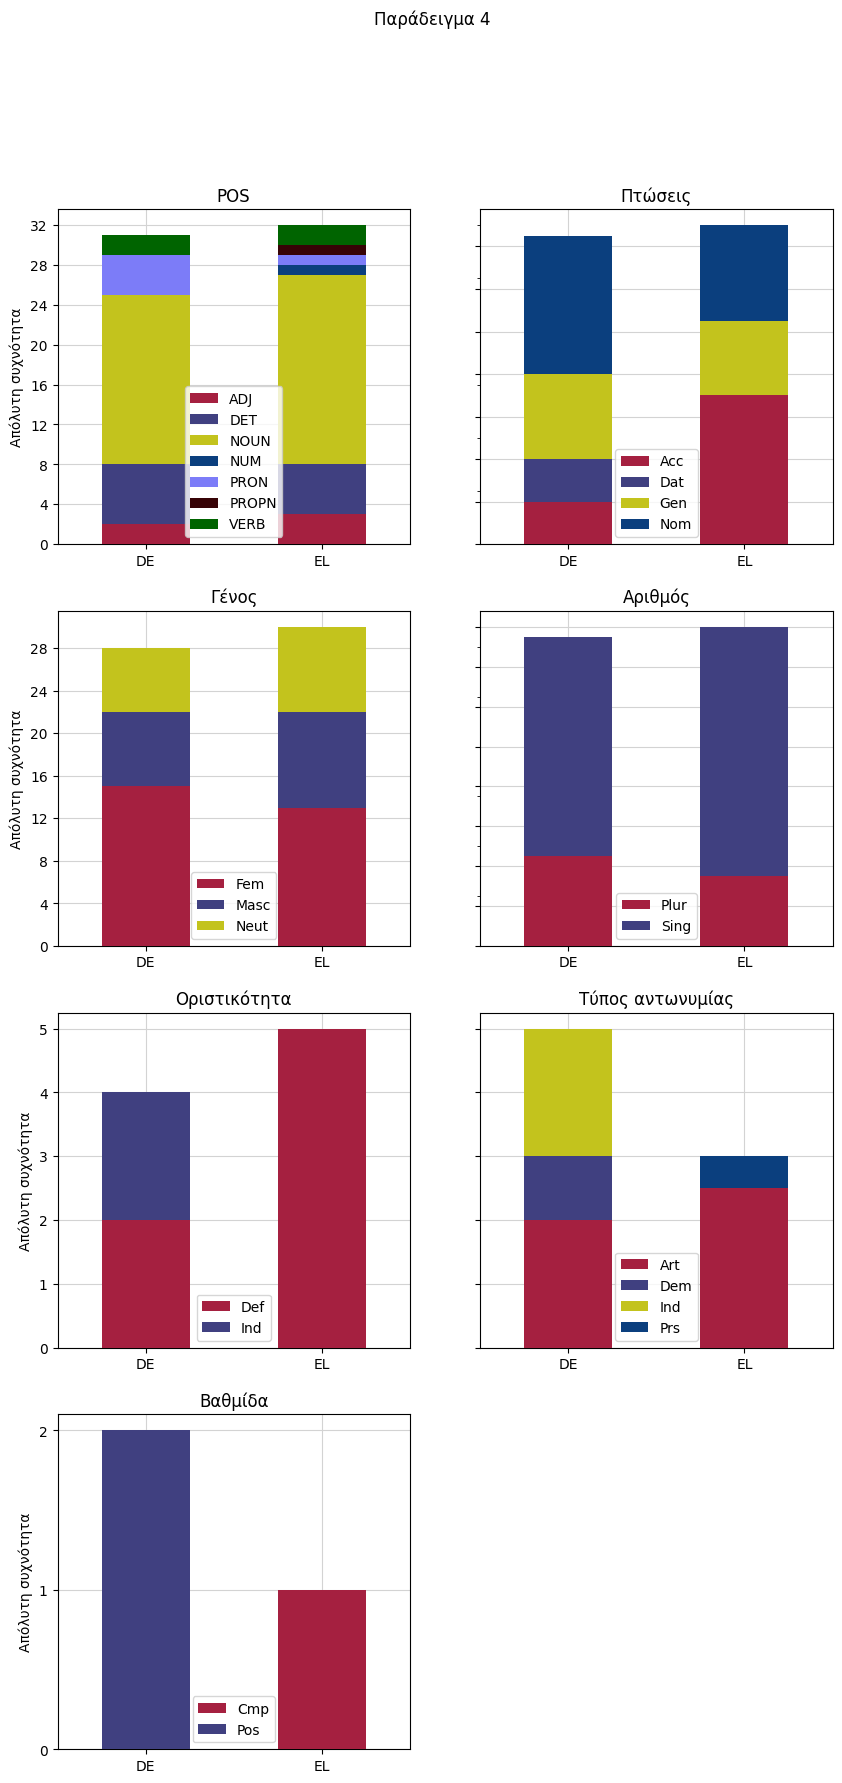

Παράδειγμα 5: Κληρονόμος δύναται να γείνῃ μόνον ὁ κατὰ τὸν χρόνον τῆς ἐπαγωγῆς τῆς κληρονομίας ἐν ζωῇ εὑρισκόμενος ἤ τουλάχιστον συνειλημμένος. (ΑΚ 1711)


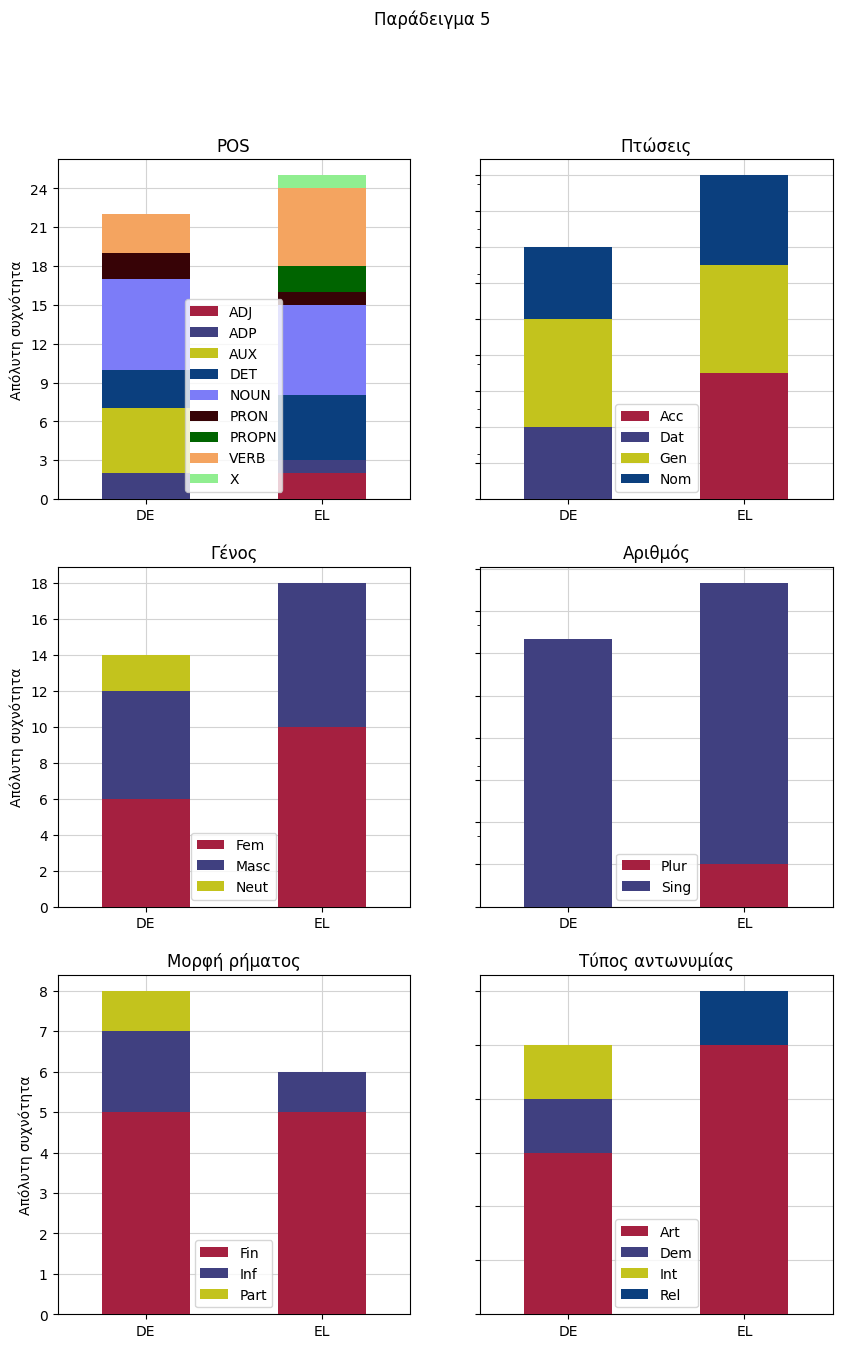

In [12]:
for i, row in analysis_df.groupby('id'):
    print(f"Παράδειγμα {i}:", row['sentence'].iloc[0])
    visualizer.visualize_morphology(row, group_by='lang')

In [13]:
# visualize morphology for all examples
# visualizer.visualize_morphology(analysis_df, group_by='id')